In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'APA Variation 6 LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Apache Corporation Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.829004,15.783375,-11.666669,832986.0,0.0
2000-01-24,17.424242,16.035816,-16.883143,3962574.0,2.0
2000-01-25,16.964287,16.178658,-27.922065,1711248.0,2.0
2000-01-26,17.153681,16.328661,-24.324314,3808959.0,2.0
2000-01-27,16.964287,16.426450,-34.399988,2355969.0,2.0


In [6]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [7]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4745, 15, 4)

In [8]:
y = labels
y = np.array(y)
y.shape

(4745,)

In [9]:
from collections import Counter

Counter(y)

Counter({2.0: 4337, 0.0: 210, 1.0: 198})

In [10]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [11]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [12]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 44ms/step - loss: 0.2952 - accuracy: 0.4934 - mse: 0.4647 - weighted_accuracy: 0.2986 - weighted_mse: 0.5495 - val_loss: 0.2998 - val_accuracy: 0.0421 - val_mse: 0.3548 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3548
Epoch 2/200
30/30 [==============================] - 0s 16ms/step - loss: 0.2110 - accuracy: 0.3264 - mse: 0.7951 - weighted_accuracy: 0.4103 - weighted_mse: 0.7819 - val_loss: 0.2913 - val_accuracy: 0.0421 - val_mse: 0.3854 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3854
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1906 - accuracy: 0.2887 - mse: 1.0278 - weighted_accuracy: 0.4759 - weighted_mse: 1.0033 - val_loss: 0.2806 - val_accuracy: 0.0421 - val_mse: 0.4240 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.4240
Epoch 4/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1827 - accuracy: 0.3106 - mse: 1.1418 - weighted_accuracy: 0.4927 - weig

Epoch 30/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1378 - accuracy: 0.4012 - mse: 1.6400 - weighted_accuracy: 0.7081 - weighted_mse: 1.5595 - val_loss: 0.1914 - val_accuracy: 0.3509 - val_mse: 1.5843 - val_weighted_accuracy: 0.3509 - val_weighted_mse: 1.5843
Epoch 31/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1362 - accuracy: 0.4328 - mse: 1.6399 - weighted_accuracy: 0.7097 - weighted_mse: 1.5714 - val_loss: 0.1879 - val_accuracy: 0.3730 - val_mse: 1.6293 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 1.6293
Epoch 32/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1354 - accuracy: 0.4415 - mse: 1.6575 - weighted_accuracy: 0.7054 - weighted_mse: 1.5916 - val_loss: 0.1883 - val_accuracy: 0.3772 - val_mse: 1.6928 - val_weighted_accuracy: 0.3772 - val_weighted_mse: 1.6928
Epoch 33/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1346 - accuracy: 0.4236 - mse: 1.6853 - weighted_accuracy: 0.7167 - 

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1122 - accuracy: 0.5732 - mse: 2.0743 - weighted_accuracy: 0.7924 - weighted_mse: 2.0696 - val_loss: 0.1794 - val_accuracy: 0.4773 - val_mse: 2.1626 - val_weighted_accuracy: 0.4773 - val_weighted_mse: 2.1626
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1106 - accuracy: 0.5661 - mse: 2.1156 - weighted_accuracy: 0.7994 - weighted_mse: 2.1085 - val_loss: 0.1588 - val_accuracy: 0.5774 - val_mse: 2.0832 - val_weighted_accuracy: 0.5774 - val_weighted_mse: 2.0832
Epoch 61/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1102 - accuracy: 0.5782 - mse: 2.1201 - weighted_accuracy: 0.8074 - weighted_mse: 2.1110 - val_loss: 0.1796 - val_accuracy: 0.4784 - val_mse: 2.2051 - val_weighted_accuracy: 0.4784 - val_weighted_mse: 2.2051
Epoch 62/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1108 - accuracy: 0.5827 - mse: 2.1410 - weighted_accuracy: 0.8089 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0891 - accuracy: 0.7021 - mse: 2.6794 - weighted_accuracy: 0.8681 - weighted_mse: 2.7336 - val_loss: 0.1914 - val_accuracy: 0.5016 - val_mse: 2.8862 - val_weighted_accuracy: 0.5016 - val_weighted_mse: 2.8862
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0892 - accuracy: 0.6970 - mse: 2.6937 - weighted_accuracy: 0.8684 - weighted_mse: 2.7295 - val_loss: 0.2235 - val_accuracy: 0.4658 - val_mse: 2.6966 - val_weighted_accuracy: 0.4658 - val_weighted_mse: 2.6966
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 0.6997 - mse: 2.7026 - weighted_accuracy: 0.8594 - weighted_mse: 2.7674 - val_loss: 0.1797 - val_accuracy: 0.5522 - val_mse: 2.8185 - val_weighted_accuracy: 0.5522 - val_weighted_mse: 2.8185
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0888 - accuracy: 0.6965 - mse: 2.7839 - weighted_accuracy: 0.8623 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.7856 - mse: 3.6033 - weighted_accuracy: 0.9102 - weighted_mse: 3.6351 - val_loss: 0.1458 - val_accuracy: 0.7028 - val_mse: 3.8059 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 3.8059
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0669 - accuracy: 0.7837 - mse: 3.5984 - weighted_accuracy: 0.9075 - weighted_mse: 3.6547 - val_loss: 0.1776 - val_accuracy: 0.6143 - val_mse: 3.9641 - val_weighted_accuracy: 0.6143 - val_weighted_mse: 3.9641
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0661 - accuracy: 0.7969 - mse: 3.6707 - weighted_accuracy: 0.9240 - weighted_mse: 3.6904 - val_loss: 0.1599 - val_accuracy: 0.6691 - val_mse: 3.6998 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 3.6998
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0662 - accuracy: 0.8032 - mse: 3.6848 - weighted_accuracy: 0.9204 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0509 - accuracy: 0.8493 - mse: 4.9120 - weighted_accuracy: 0.9412 - weighted_mse: 4.8468 - val_loss: 0.1697 - val_accuracy: 0.7155 - val_mse: 5.1168 - val_weighted_accuracy: 0.7155 - val_weighted_mse: 5.1168
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.8556 - mse: 4.9445 - weighted_accuracy: 0.9414 - weighted_mse: 4.9021 - val_loss: 0.1695 - val_accuracy: 0.7144 - val_mse: 4.9158 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 4.9158
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.8530 - mse: 5.0714 - weighted_accuracy: 0.9368 - weighted_mse: 4.9782 - val_loss: 0.1653 - val_accuracy: 0.7165 - val_mse: 5.2177 - val_weighted_accuracy: 0.7165 - val_weighted_mse: 5.2177
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.8670 - mse: 5.1419 - weighted_accuracy: 0.9475 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.8830 - mse: 6.6201 - weighted_accuracy: 0.9458 - weighted_mse: 6.2133 - val_loss: 0.2100 - val_accuracy: 0.6733 - val_mse: 6.6310 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 6.6310
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.8733 - mse: 6.5670 - weighted_accuracy: 0.9442 - weighted_mse: 6.1711 - val_loss: 0.2007 - val_accuracy: 0.7102 - val_mse: 6.5644 - val_weighted_accuracy: 0.7102 - val_weighted_mse: 6.5644
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9002 - mse: 6.7204 - weighted_accuracy: 0.9597 - weighted_mse: 6.2937 - val_loss: 0.1826 - val_accuracy: 0.7418 - val_mse: 7.2152 - val_weighted_accuracy: 0.7418 - val_weighted_mse: 7.2152
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.8970 - mse: 6.7208 - weighted_accuracy: 0.9587 - 

In [16]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21389976143836975
Test accuracy: 0.7239199280738831


In [17]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.770816  -1.675848  -0.9161013]
 [-0.5665975 -3.7139285  0.0623514]
 [-2.9027612 -3.9624562  2.005799 ]
 ...
 [-2.971507  -1.8826481  1.6327443]
 [-2.087935  -5.650486   1.4440925]
 [-4.7506585 -2.035533   1.8096812]]


Counter({0: 106, 2: 739, 1: 104})

In [18]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 42, 1: 40})

In [19]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 9
actual buys but predicted sell: 3
actual buys but predicted hold: 28
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 37
actual holds but predicted buy: 94
actual holds but predicted sell: 99
actual predicted holds: 674
Percentage buys correct: 22.5%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 77.73933102652826%
actual buys: 40
actual sells: 42
actual holds: 867


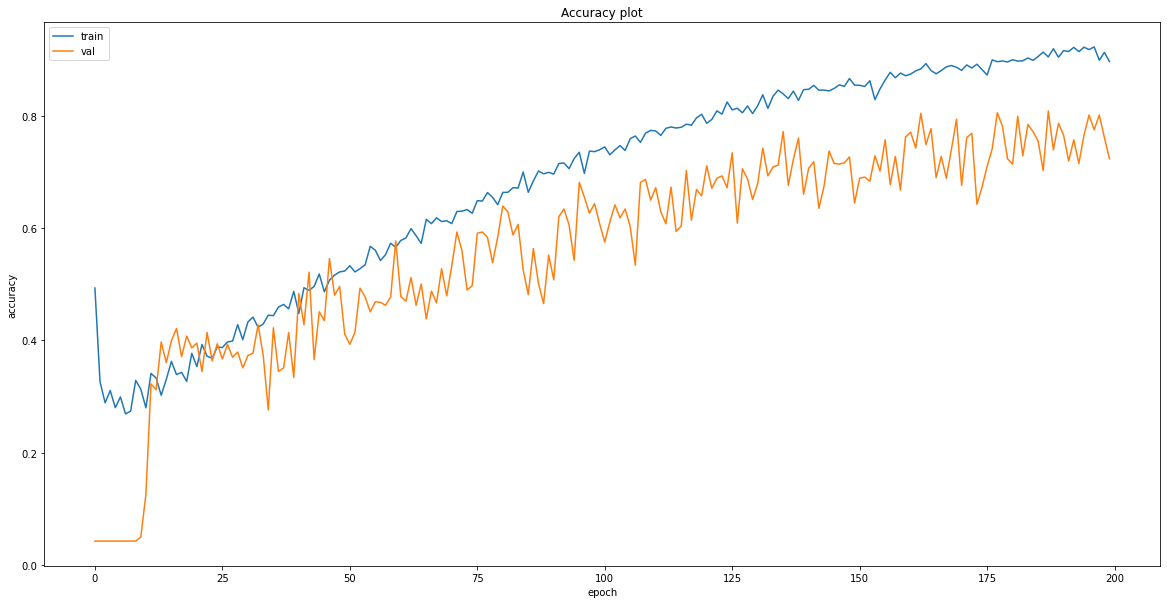

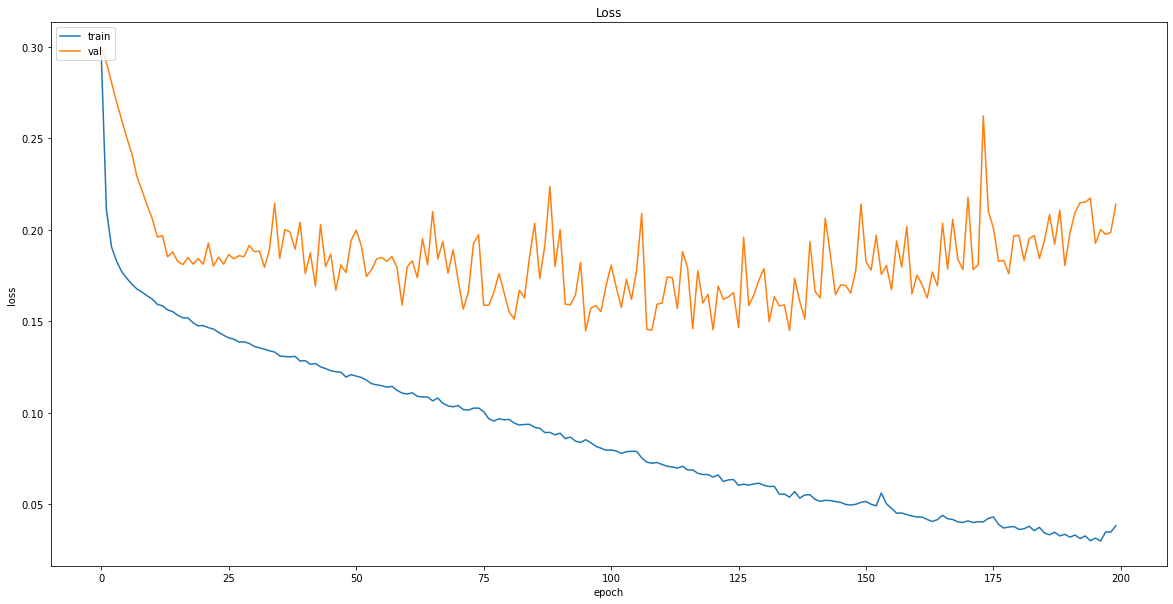

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# Save model
model.save("models/{}".format('APA_no_support_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/APA_no_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [22]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [23]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,32.090000,30.219349,-6.069339,51546400.0,2.0
2019-01-23,31.520000,30.419449,-14.306331,47385100.0,1.0
2019-01-24,30.969999,30.504149,-26.101688,43194000.0,2.0
2019-01-25,31.840000,30.709665,-13.293617,47637700.0,2.0
2019-01-28,32.060001,30.917409,-9.803859,52112900.0,2.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/APA_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.2350 - accuracy: 0.7110 - mean_squared_error: 8.5293 - weighted_accuracy: 0.7110 - weighted_mean_squared_error: 8.5293
Test loss: 0.235011488199234
Test accuracy: 0.71100914478302


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 0: 21, 1: 30})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 8, 1: 9})

In [30]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)

In [31]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,29.870001,31.958706,-90.214020,48889800.0,1.0,2,2
2019-02-11,30.350000,31.637367,-86.778818,44501400.0,2.0,2,2
2019-02-12,31.080000,31.439311,-75.240367,47729600.0,2.0,2,2
2019-02-13,32.279999,31.384032,-57.692301,52547300.0,2.0,0,2
2019-02-14,32.669998,31.521873,-28.846173,57269000.0,2.0,2,2


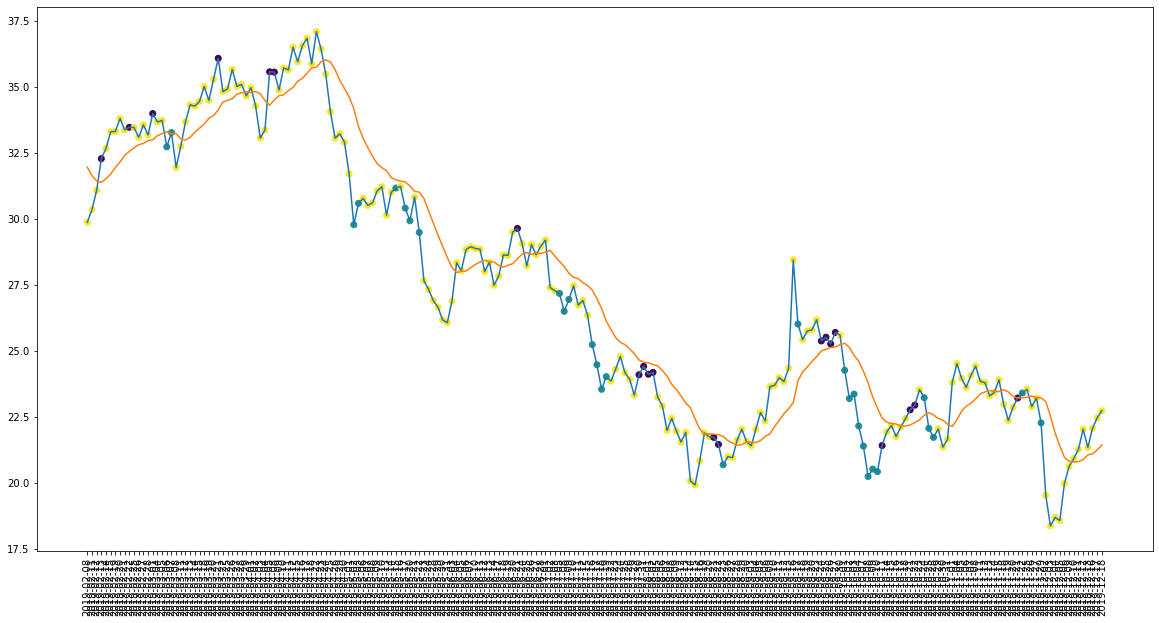

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 27
actual holds but predicted sell: 21
actual predicted holds: 153
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 0.0%
Percentage holds correct: 76.11940298507463%
actual buys: 9
actual sells: 8
actual holds: 201


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[29.8700008392334, 30.35000038146973, 31.07999992370605, 32.279998779296875, 32.669998168945305, 33.299999237060554, 33.310001373291016, 33.36999893188477, 33.799999237060554]
[33.09000015258789, 33.18000030517578, 33.310001373291016, 33.36999893188477, 33.459999084472656, 33.470001220703125, 33.560001373291016, 33.799999237060554, 33.990001678466804]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 61.904761904761905%
Percentage holds correct: 82.63473053892216%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $32.72999954223633
Shares owned at the moment: 304
Cash capital at the moment: $22.71785954284678


Price increase from previously bought: 9.932949697441984%
Share price: $36.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $10960.87553465271


Share price: $29.78000068664551
Shares owned at the moment: 367
Cash capital at the moment: $1.5598169608092576


Stop Loss Activated!

Share price: $27.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10124.863906115052


Share price: $27.18000030517578
Shares owned at the moment: 371
Cash capital at the moment: $13.353397583481637


Stop Loss Activated!

Share price: $26.35000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9762.319951219557


Share price: $25.239999771118164
Shares owned at the moment: 385
Cash capital at the moment: $18.197189581391285


Stop Loss Activated!

Share price: $24.479999542236328
Shares owned at the moment: 0
Cash capital at the mom

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7577.532036258697
profit gained: -24.224679637413026%


In [37]:
logger

[0.71100914478302,
 '22.22222222222222%',
 '0.0%',
 '76.11940298507463%',
 '53.333333333333336%',
 '61.904761904761905%',
 '82.63473053892216%',
 '-34.149987268161844%',
 '-24.224679637413026%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.711009,22.22222222222222%,0.0%,76.11940298507463%,53.333333333333336%,61.904761904761905%,82.63473053892216%,-34.149987268161844%,-24.224679637413026%


### Recession Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/APA_no_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.2043 - accuracy: 0.7443 - mean_squared_error: 7.6384 - weighted_accuracy: 0.7443 - weighted_mean_squared_error: 7.6384
Test loss: 0.20434969663619995
Test accuracy: 0.7442922592163086


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 1: 23, 0: 22})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,27.969999,28.755177,-79.965463,10113400.0,2.0,2,2
2020-02-11,28.170000,28.634380,-77.333366,7103100.0,2.0,2,2
2020-02-12,28.480000,28.562937,-66.847830,9173500.0,2.0,1,2
2020-02-13,27.920000,28.550178,-51.118237,12393300.0,2.0,1,2
2020-02-14,27.360001,28.453227,-61.811036,8895100.0,2.0,1,2


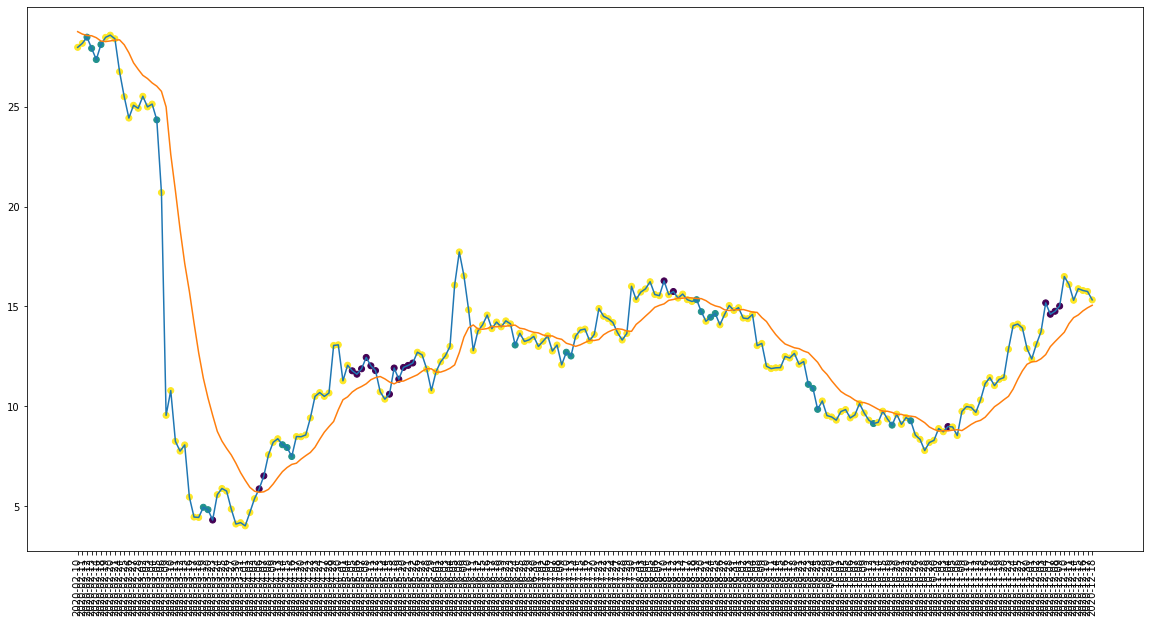

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 22
actual holds but predicted sell: 21
actual predicted holds: 161
Percentage buys correct: 12.5%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 78.92156862745098%
actual buys: 8
actual sells: 7
actual holds: 204


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[27.36000061035156, 27.920000076293945, 27.96999931335449, 28.11000061035156, 28.170000076293945, 28.399999618530273, 28.46999931335449, 28.479999542236328, 28.57999992370605]
[24.43000030517578, 24.920000076293945, 25.06999969482422, 25.5, 25.520000457763672, 26.75, 28.399999618530273, 28.46999931335449, 28.57999992370605]
Percentage buys correct: 52.17391304347826%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 84.48275862068965%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.479999542236328
Shares owned at the moment: 350
Cash capital at the moment: $4.588160657882327


Stop Loss Activated!

Share price: $27.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9554.254373693464


Share price: $27.36000061035156
Shares owned at the moment: 348
Cash capital at the moment: $6.790640707014973


Stop Loss Activated!

Share price: $25.5
Shares owned at the moment: 0
Cash capital at the moment: $8856.387140707015


Share price: $24.34000015258789
Shares owned at the moment: 362
Cash capital at the moment: $21.076615318295808


Stop Loss Activated!

Share price: $20.700000762939453
Shares owned at the moment: 0
Cash capital at the moment: $7493.870040742871


Share price: $4.949999809265137
Shares owned at the moment: 1509
Cash capital at the moment: $3.77906685328162


Stop Loss Activated!

Share price: $4.309999942779541
Shares owned at the moment: 0
Cash capital at the moment: $6489.683558245059


Share price: $8.0799999237

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5457.769518032075
profit gained: -45.42230481967925%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.711009,22.22222222222222%,0.0%,76.11940298507463%,53.333333333333336%,61.904761904761905%,82.63473053892216%,-34.149987268161844%,-24.224679637413026%
1,0.744292,12.5%,14.285714285714286%,78.92156862745098%,52.17391304347826%,45.45454545454545%,84.48275862068965%,-28.46887489548571%,-45.42230481967925%


### with XOM stock price

In [55]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.829004,15.783375,-11.666669,832986.0,0.0
2000-01-24,17.424242,16.035816,-16.883143,3962574.0,2.0
2000-01-25,16.964287,16.178658,-27.922065,1711248.0,2.0
2000-01-26,17.153681,16.328661,-24.324314,3808959.0,2.0
2000-01-27,16.964287,16.426450,-34.399988,2355969.0,2.0


In [56]:
df2 = pd.read_csv("data/variation 6/initial_indicators/XOM_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,41.84375,41.600345,-26.282051,1187400.0,2.0
2000-01-24,42.50000,41.738754,-12.820513,15531000.0,2.0
2000-01-25,42.12500,41.798176,-21.019108,3071600.0,2.0
2000-01-26,42.03125,41.834034,-26.470588,-8850000.0,2.0
2000-01-27,41.75000,41.821105,-45.918367,-18148000.0,2.0


In [57]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2000-01-21,16.829004,15.783375,-11.666669,832986.0,41.84375,0.0
2000-01-24,17.424242,16.035816,-16.883143,3962574.0,42.50000,2.0
2000-01-25,16.964287,16.178658,-27.922065,1711248.0,42.12500,2.0
2000-01-26,17.153681,16.328661,-24.324314,3808959.0,42.03125,2.0
2000-01-27,16.964287,16.426450,-34.399988,2355969.0,41.75000,2.0


In [58]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [59]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(4745, 15, 5)

In [60]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [61]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [62]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [64]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 45ms/step - loss: 0.2970 - accuracy: 0.5506 - mse: 0.4368 - weighted_accuracy: 0.3190 - weighted_mse: 0.5311 - val_loss: 0.3012 - val_accuracy: 0.0390 - val_mse: 0.3541 - val_weighted_accuracy: 0.0390 - val_weighted_mse: 0.3541
Epoch 2/200
30/30 [==============================] - 1s 17ms/step - loss: 0.2130 - accuracy: 0.3865 - mse: 0.7561 - weighted_accuracy: 0.4346 - weighted_mse: 0.7537 - val_loss: 0.2929 - val_accuracy: 0.0421 - val_mse: 0.3803 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.3803
Epoch 3/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1913 - accuracy: 0.3109 - mse: 0.9984 - weighted_accuracy: 0.4727 - weighted_mse: 0.9721 - val_loss: 0.2809 - val_accuracy: 0.0421 - val_mse: 0.4147 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.4147
Epoch 4/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1823 - accuracy: 0.3114 - mse: 1.1281 - weighted_accuracy: 0.4925 - weig

Epoch 29/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1300 - accuracy: 0.4792 - mse: 1.6088 - weighted_accuracy: 0.7506 - weighted_mse: 1.5624 - val_loss: 0.1855 - val_accuracy: 0.3888 - val_mse: 1.5628 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 1.5628
Epoch 30/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1282 - accuracy: 0.4555 - mse: 1.6376 - weighted_accuracy: 0.7610 - weighted_mse: 1.5732 - val_loss: 0.1893 - val_accuracy: 0.3888 - val_mse: 1.6382 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 1.6382
Epoch 31/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1270 - accuracy: 0.4897 - mse: 1.6328 - weighted_accuracy: 0.7692 - weighted_mse: 1.5867 - val_loss: 0.1863 - val_accuracy: 0.4046 - val_mse: 1.6072 - val_weighted_accuracy: 0.4046 - val_weighted_mse: 1.6072
Epoch 32/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1251 - accuracy: 0.5021 - mse: 1.6619 - weighted_accuracy: 0.7701 - 

Epoch 58/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0960 - accuracy: 0.6541 - mse: 2.2342 - weighted_accuracy: 0.8604 - weighted_mse: 2.2722 - val_loss: 0.1808 - val_accuracy: 0.5174 - val_mse: 2.2307 - val_weighted_accuracy: 0.5174 - val_weighted_mse: 2.2307
Epoch 59/200
30/30 [==============================] - 0s 12ms/step - loss: 0.0938 - accuracy: 0.6736 - mse: 2.2817 - weighted_accuracy: 0.8678 - weighted_mse: 2.3178 - val_loss: 0.1886 - val_accuracy: 0.5026 - val_mse: 2.3220 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 2.3220
Epoch 60/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0918 - accuracy: 0.6812 - mse: 2.3294 - weighted_accuracy: 0.8722 - weighted_mse: 2.3772 - val_loss: 0.1530 - val_accuracy: 0.6228 - val_mse: 2.2623 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 2.2623
Epoch 61/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0923 - accuracy: 0.6657 - mse: 2.3586 - weighted_accuracy: 0.8625 - 

Epoch 87/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0683 - accuracy: 0.7940 - mse: 3.4465 - weighted_accuracy: 0.9152 - weighted_mse: 3.5419 - val_loss: 0.1693 - val_accuracy: 0.6660 - val_mse: 3.4936 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 3.4936
Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.7966 - mse: 3.4585 - weighted_accuracy: 0.9201 - weighted_mse: 3.5677 - val_loss: 0.1745 - val_accuracy: 0.6322 - val_mse: 3.5446 - val_weighted_accuracy: 0.6322 - val_weighted_mse: 3.5446
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.8008 - mse: 3.5008 - weighted_accuracy: 0.9236 - weighted_mse: 3.5851 - val_loss: 0.2037 - val_accuracy: 0.5796 - val_mse: 3.5970 - val_weighted_accuracy: 0.5796 - val_weighted_mse: 3.5970
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0643 - accuracy: 0.7985 - mse: 3.5259 - weighted_accuracy: 0.9190 - weig

Epoch 116/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8754 - mse: 5.2548 - weighted_accuracy: 0.9507 - weighted_mse: 5.2209 - val_loss: 0.1884 - val_accuracy: 0.7102 - val_mse: 5.4839 - val_weighted_accuracy: 0.7102 - val_weighted_mse: 5.4839
Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0444 - accuracy: 0.8754 - mse: 5.3124 - weighted_accuracy: 0.9546 - weighted_mse: 5.2149 - val_loss: 0.1712 - val_accuracy: 0.7482 - val_mse: 5.6849 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 5.6849
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.8833 - mse: 5.3225 - weighted_accuracy: 0.9537 - weighted_mse: 5.3243 - val_loss: 0.1780 - val_accuracy: 0.7323 - val_mse: 5.5625 - val_weighted_accuracy: 0.7323 - val_weighted_mse: 5.5625
Epoch 119/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0405 - accuracy: 0.8878 - mse: 5.4632 - weighted_accuracy: 0.9591 - 

Epoch 145/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0303 - accuracy: 0.9160 - mse: 7.5311 - weighted_accuracy: 0.9694 - weighted_mse: 7.1571 - val_loss: 0.2115 - val_accuracy: 0.7829 - val_mse: 8.4516 - val_weighted_accuracy: 0.7829 - val_weighted_mse: 8.4516
Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9289 - mse: 7.6415 - weighted_accuracy: 0.9722 - weighted_mse: 7.1512 - val_loss: 0.2439 - val_accuracy: 0.6997 - val_mse: 7.9355 - val_weighted_accuracy: 0.6997 - val_weighted_mse: 7.9355
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9231 - mse: 7.6891 - weighted_accuracy: 0.9699 - weighted_mse: 7.2115 - val_loss: 0.2238 - val_accuracy: 0.7661 - val_mse: 8.5309 - val_weighted_accuracy: 0.7661 - val_weighted_mse: 8.5309
Epoch 148/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0265 - accuracy: 0.9355 - mse: 7.8263 - weighted_accuracy: 0.9765 - 

Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9526 - mse: 10.3396 - weighted_accuracy: 0.9808 - weighted_mse: 9.2853 - val_loss: 0.2657 - val_accuracy: 0.7787 - val_mse: 10.3772 - val_weighted_accuracy: 0.7787 - val_weighted_mse: 10.3772
Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0223 - accuracy: 0.9484 - mse: 10.4983 - weighted_accuracy: 0.9773 - weighted_mse: 9.5220 - val_loss: 0.2663 - val_accuracy: 0.7597 - val_mse: 11.0739 - val_weighted_accuracy: 0.7597 - val_weighted_mse: 11.0739
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9463 - mse: 10.3079 - weighted_accuracy: 0.9765 - weighted_mse: 9.3222 - val_loss: 0.2873 - val_accuracy: 0.7460 - val_mse: 10.7646 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 10.7646
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0235 - accuracy: 0.9413 - mse: 10.4362 - weighted_accuracy:

In [65]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2986975312232971
Test accuracy: 0.822971522808075


In [66]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.9606414  -2.3435261   0.74827313]
 [-4.0372605  -4.4321475   2.7342992 ]
 [-3.2204409  -5.297681    2.3746653 ]
 ...
 [-3.8084474  -2.5744066   2.8163805 ]
 [-2.9217248  -6.9613123   2.7612786 ]
 [-4.778864   -1.4491105   1.3696966 ]]


Counter({2: 861, 0: 47, 1: 41})

In [67]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 42, 1: 40})

In [68]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 42
actual holds but predicted buy: 40
actual holds but predicted sell: 47
actual predicted holds: 780
Percentage buys correct: 2.5%
Percentage sells correct: 0.0%
Percentage holds correct: 89.96539792387543%
actual buys: 40
actual sells: 42
actual holds: 867


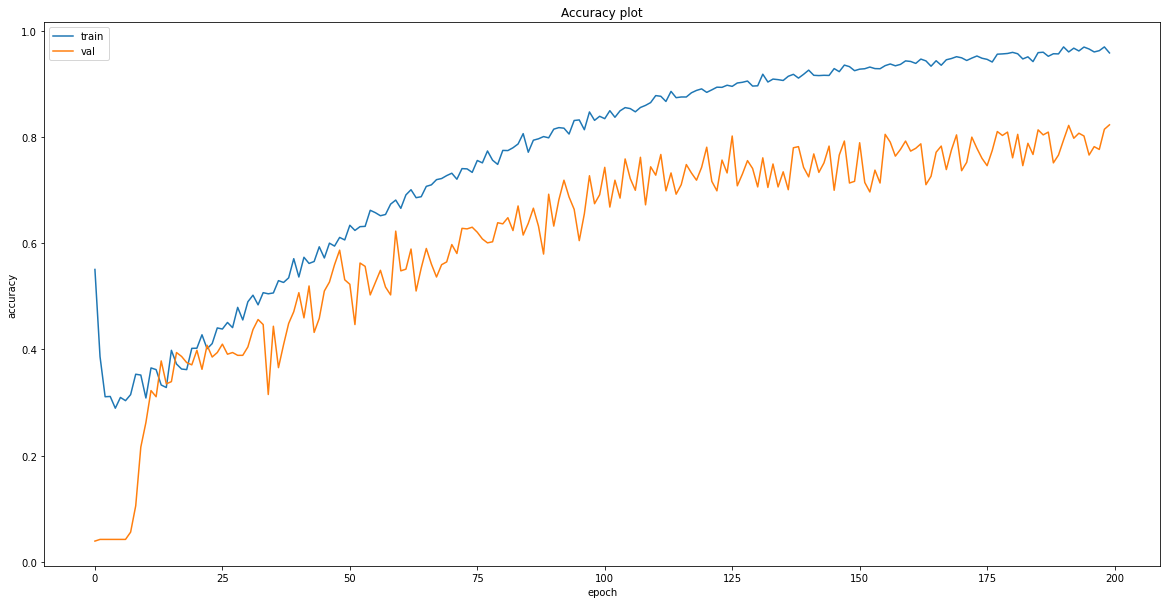

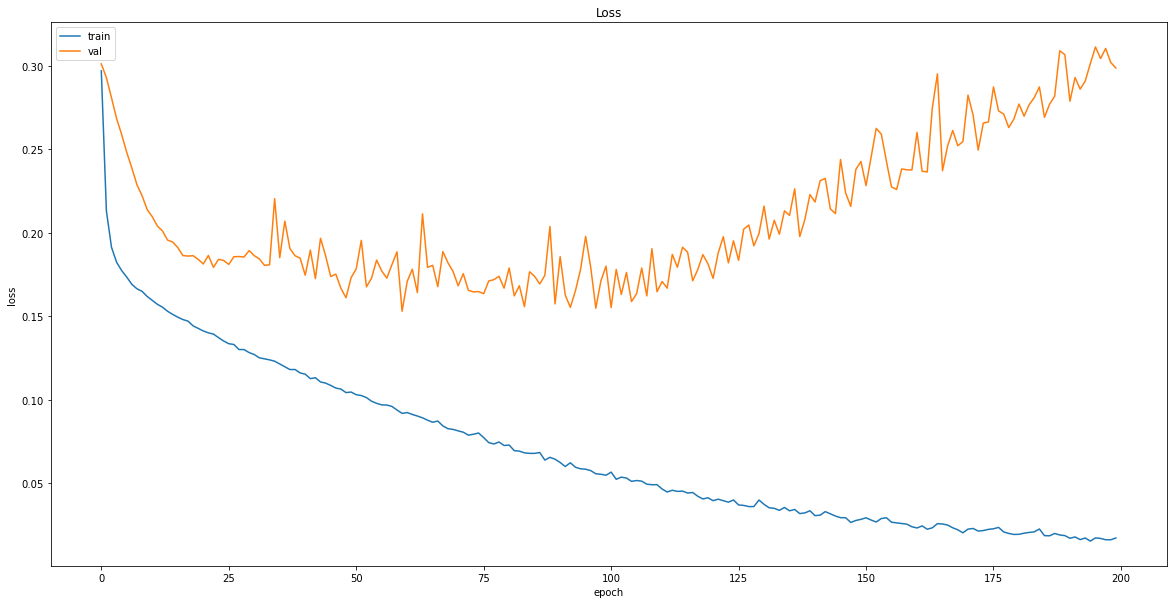

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Save model
model.save("models/{}".format('APA_support_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/APA_support_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [71]:
logger = []

In [72]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    32.090000  30.219349  -6.069339  51546400.0     2.0
2019-01-23    31.520000  30.419449 -14.306331  47385100.0     1.0
2019-01-24    30.969999  30.504149 -26.101688  43194000.0     2.0
2019-01-25    31.840000  30.709665 -13.293617  47637700.0     2.0
2019-01-28    32.060001  30.917409  -9.803859  52112900.0     2.0


In [73]:
df2 = pd.read_csv("data/variation 6/initial_indicators/XOM_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,72.989998,71.473540,-4.975176,60118400.0,2.0
2019-01-23,71.889999,71.537611,-23.217277,45082800.0,2.0
2019-01-24,71.300003,71.501056,-40.365066,31895600.0,2.0
2019-01-25,71.400002,71.485509,-48.091584,43168100.0,2.0
2019-01-28,71.720001,71.521585,-59.245237,52164300.0,1.0


In [74]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2019-01-22,32.090000,30.219349,-6.069339,51546400.0,72.989998,2.0
2019-01-23,31.520000,30.419449,-14.306331,47385100.0,71.889999,1.0
2019-01-24,30.969999,30.504149,-26.101688,43194000.0,71.300003,2.0
2019-01-25,31.840000,30.709665,-13.293617,47637700.0,71.400002,2.0
2019-01-28,32.060001,30.917409,-9.803859,52112900.0,71.720001,2.0


In [75]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [76]:
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(218, 15, 5)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/APA_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2283 - accuracy: 0.8349 - mean_squared_error: 14.8037 - weighted_accuracy: 0.8349 - weighted_mean_squared_error: 14.8037
Test loss: 0.22829119861125946
Test accuracy: 0.8348624110221863


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 197, 0: 7, 1: 14})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 8, 1: 9})

In [81]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test.csv")
df.set_index('Date', inplace=True)

In [82]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,30.350000,31.637367,-86.778818,44501400.0,2.0,2,2
2019-02-12,31.080000,31.439311,-75.240367,47729600.0,2.0,2,2
2019-02-13,32.279999,31.384032,-57.692301,52547300.0,2.0,2,2
2019-02-14,32.669998,31.521873,-28.846173,57269000.0,2.0,2,2
2019-02-15,33.299999,31.698508,-19.471188,61241600.0,2.0,2,2


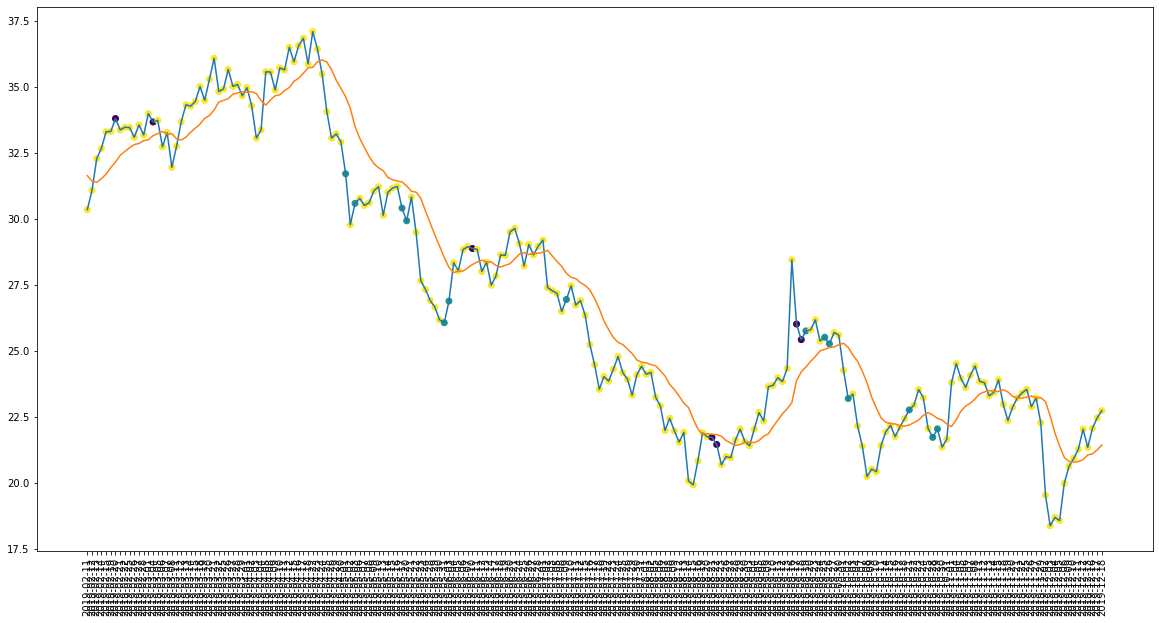

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

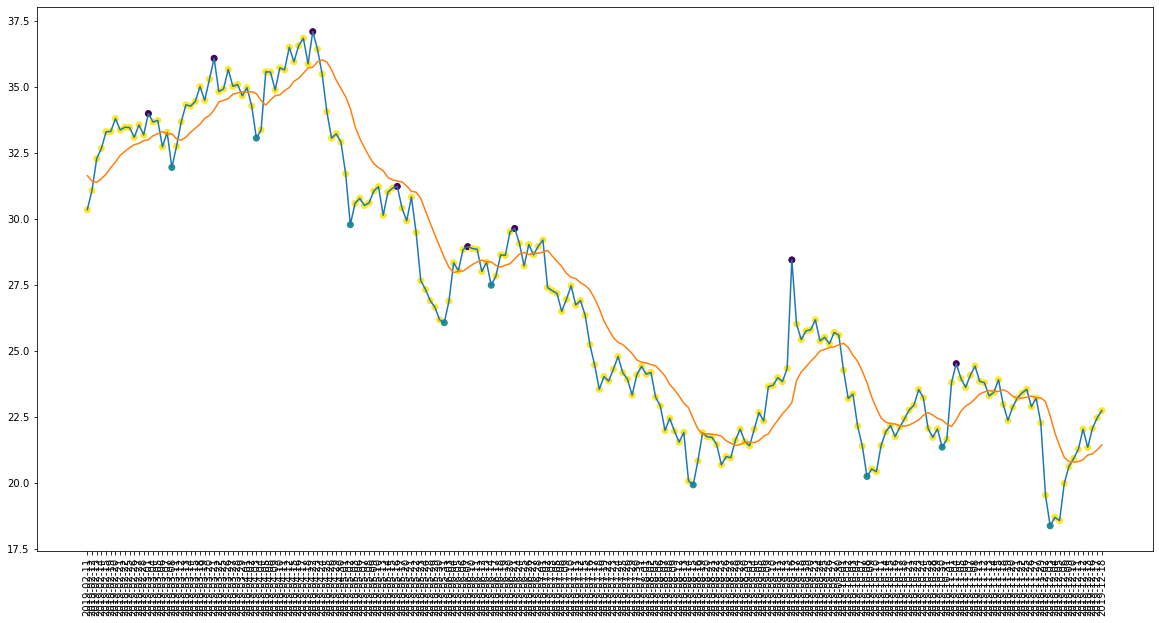

In [84]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 7
actual predicted holds: 181
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 0.0%
Percentage holds correct: 90.04975124378109%
actual buys: 9
actual sells: 8
actual holds: 201


In [86]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[30.35000038146973, 31.07999992370605, 32.279998779296875, 32.669998168945305, 33.299999237060554, 33.310001373291016, 33.36999893188477, 33.470001220703125, 33.799999237060554]
[33.09000015258789, 33.18000030517578, 33.36999893188477, 33.459999084472656, 33.470001220703125, 33.560001373291016, 33.669998168945305, 33.799999237060554, 33.990001678466804]
Percentage buys correct: 64.28571428571429%
Percentage sells correct: 71.42857142857143%
Percentage holds correct: 81.12244897959184%


In [87]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $31.709999084472656
Shares owned at the moment: 314
Cash capital at the moment: $15.678703266143202


Stop Loss Activated!

Share price: $29.78000068664551
Shares owned at the moment: 0
Cash capital at the moment: $9340.883888279915


Share price: $30.59000015258789
Shares owned at the moment: 304
Cash capital at the moment: $15.95060176563311


Stop Loss Activated!

Share price: $29.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8956.2568923769


Share price: $26.06999969482422
Shares owned at the moment: 342
Cash capital at the moment: $15.798162034034249


Price increase from previously bought: 10.474865002854239%
Share price: $28.8799991607666
Shares owned at the moment: 0
Cash capital at the moment: $9865.596235805511


Share price: $26.95000076293945
Shares owned at the moment: 365
Cash capital at the moment: $1.7948940668120485


Stop Loss Activated!

Share price: $25.239999771118164
Shares owned at the moment: 0
Cash capital at the momen

In [88]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7456.032619667051
profit gained: -25.439673803329487%


In [89]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.711009,22.22222222222222%,0.0%,76.11940298507463%,53.333333333333336%,61.904761904761905%,82.63473053892216%,-34.149987268161844%,-24.224679637413026%
1,0.744292,12.5%,14.285714285714286%,78.92156862745098%,52.17391304347826%,45.45454545454545%,84.48275862068965%,-28.46887489548571%,-45.42230481967925%
2,0.834862,11.11111111111111%,0.0%,90.04975124378109%,64.28571428571429%,71.42857142857143%,81.12244897959184%,-29.459912360076924%,-25.439673803329487%


### recession test data

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    31.740000  30.898076 -22.580653  22551800.0     2.0
2020-01-23    30.870001  30.893757 -33.564805  17841100.0     2.0
2020-01-24    30.270000  30.797795 -40.697673  13024900.0     2.0
2020-01-27    29.980000  30.671980 -44.069776   9552800.0     2.0
2020-01-28    28.850000  30.391675 -95.533989   5310000.0     2.0


In [92]:
df2 = pd.read_csv("data/variation 6/initial_indicators/XOM_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,67.580002,69.273773,-98.186537,-68570400.0,2.0
2020-01-23,67.190002,68.953193,-95.652121,-85603500.0,2.0
2020-01-24,66.769997,68.617316,-86.466285,-105209400.0,2.0
2020-01-27,66.320000,68.263883,-94.736865,-123448000.0,2.0
2020-01-28,64.739998,67.721747,-99.312699,-144679000.0,2.0


In [93]:
labels = df['labels'].values
df.drop(['labels'], axis='columns', inplace=True)
df['support'] = df2['previous_1d']
df['labels'] = labels
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,support,labels
Date,,,,,,
2020-01-22,31.740000,30.898076,-22.580653,22551800.0,67.580002,2.0
2020-01-23,30.870001,30.893757,-33.564805,17841100.0,67.190002,2.0
2020-01-24,30.270000,30.797795,-40.697673,13024900.0,66.769997,2.0
2020-01-27,29.980000,30.671980,-44.069776,9552800.0,66.320000,2.0
2020-01-28,28.850000,30.391675,-95.533989,5310000.0,64.739998,2.0


In [94]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 5)
y = labels
y = np.array(y)
X.shape

(219, 15, 5)

In [95]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [96]:
model = tf.keras.models.load_model("models/APA_support_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.8311 - mean_squared_error: 13.3133 - weighted_accuracy: 0.8311 - weighted_mean_squared_error: 13.3133
Test loss: 0.19469058513641357
Test accuracy: 0.8310502171516418


In [97]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 194, 1: 14, 0: 11})

In [98]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [99]:
df = pd.read_csv("data/variation 6/initial_indicators/APA_data_test2.csv")
df.set_index('Date', inplace=True)

In [100]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,28.170000,28.634380,-77.333366,7103100.0,2.0,2,2
2020-02-12,28.480000,28.562937,-66.847830,9173500.0,2.0,2,2
2020-02-13,27.920000,28.550178,-51.118237,12393300.0,2.0,2,2
2020-02-14,27.360001,28.453227,-61.811036,8895100.0,2.0,1,2
2020-02-18,28.110001,28.285039,-83.534141,4602800.0,2.0,2,2


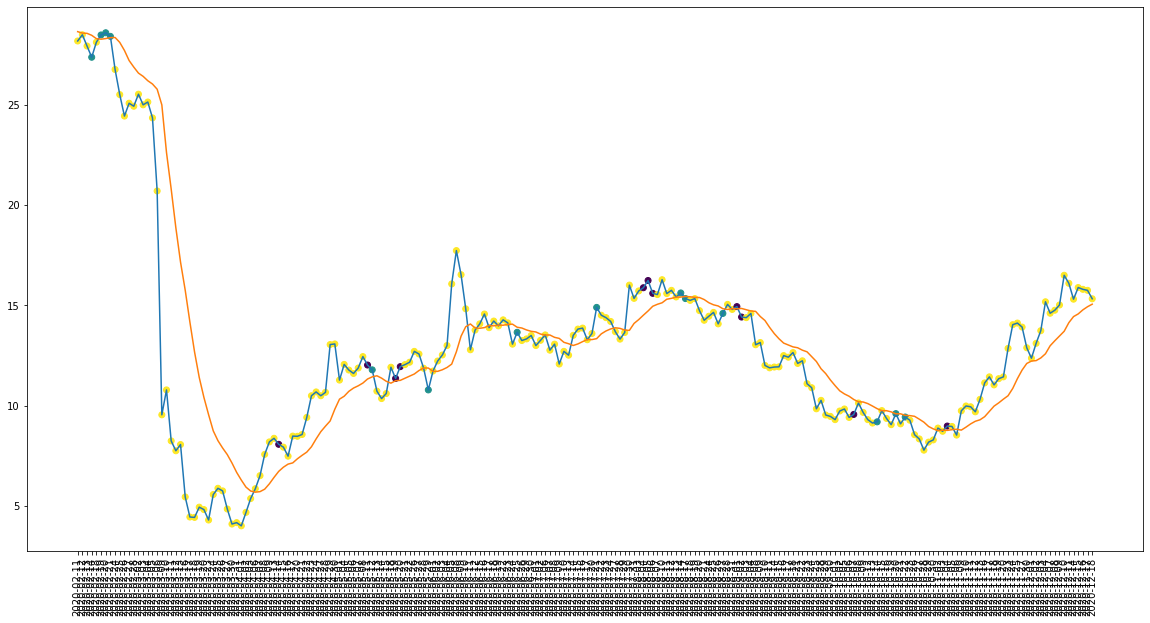

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

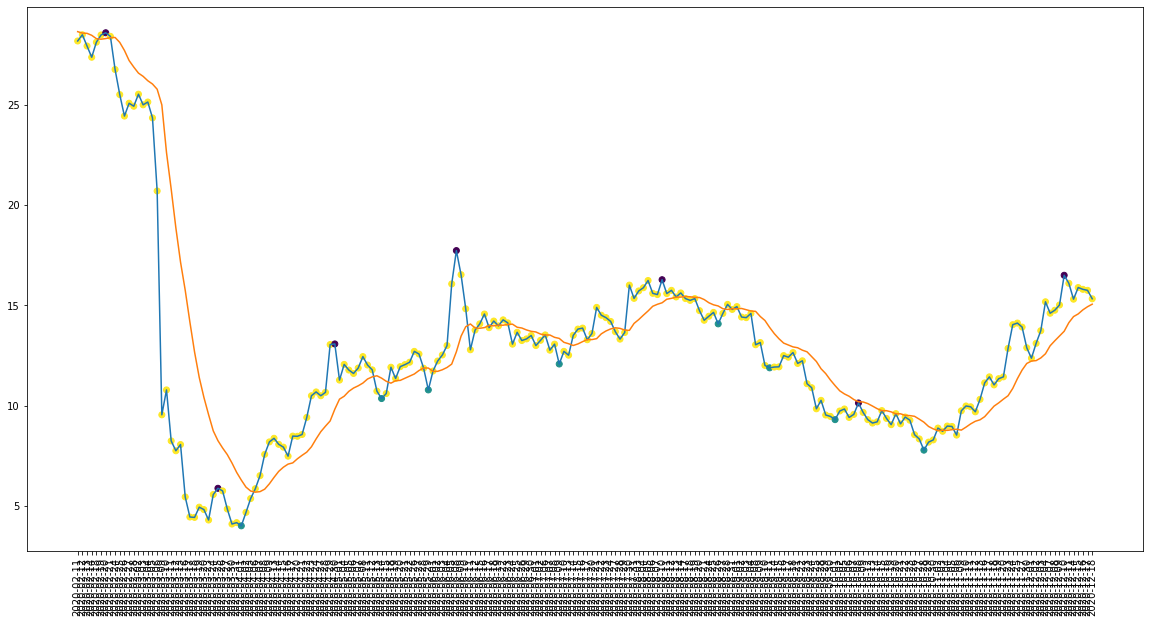

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 11
actual predicted holds: 181
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 88.72549019607843%
actual buys: 8
actual sells: 7
actual holds: 204


In [104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[26.75, 27.36000061035156, 27.920000076293945, 28.11000061035156, 28.170000076293945, 28.399999618530273, 28.46999931335449, 28.479999542236328, 28.57999992370605]
[24.43000030517578, 24.920000076293945, 24.989999771118164, 25.06999969482422, 25.5, 25.520000457763672, 26.75, 28.399999618530273, 28.57999992370605]
Percentage buys correct: 21.428571428571427%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 84.4559585492228%


In [105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.36000061035156
Shares owned at the moment: 364
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $25.5
Shares owned at the moment: 0
Cash capital at the moment: $9270.04691722107


Share price: $11.789999961853027
Shares owned at the moment: 784
Cash capital at the moment: $1.26770721054163


Stop Loss Activated!

Share price: $10.729999542236328
Shares owned at the moment: 0
Cash capital at the moment: $8390.453469310762


Share price: $10.789999961853027
Shares owned at the moment: 775
Cash capital at the moment: $5.207311455966192


Price increase from previously bought: 46.76969354278589%
Share price: $15.880000114440918
Shares owned at the moment: 0
Cash capital at the moment: $12278.363149903775


Share price: $15.619999885559082
Shares owned at the moment: 783
Cash capital at the moment: $14.269474757433272


Stop Loss Activated!

Share price: $14.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $11523.

In [106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5412.292695983887
profit gained: -45.87707304016113%


In [107]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.711009,22.22222222222222%,0.0%,76.11940298507463%,53.333333333333336%,61.904761904761905%,82.63473053892216%,-34.149987268161844%,-24.224679637413026%
1,0.744292,12.5%,14.285714285714286%,78.92156862745098%,52.17391304347826%,45.45454545454545%,84.48275862068965%,-28.46887489548571%,-45.42230481967925%
2,0.834862,11.11111111111111%,0.0%,90.04975124378109%,64.28571428571429%,71.42857142857143%,81.12244897959184%,-29.459912360076924%,-25.439673803329487%
3,0.831050,12.5%,0.0%,88.72549019607843%,21.428571428571427%,45.45454545454545%,84.4559585492228%,-5.275126937637324%,-45.87707304016113%


In [108]:
experiment

'APA Variation 6 LSTM Time Series'

In [109]:
log.to_csv('{}.csv'.format(experiment))